In [0]:
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'horse','ship', 'truck'}

background_classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog'}

# print(type(foreground_classes))

In [0]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)
    

In [0]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

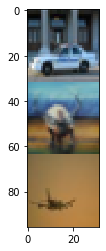

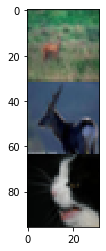

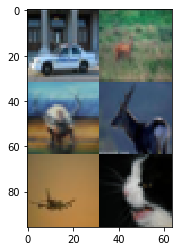

torch.Size([3, 96, 32])


In [0]:
img1 = torch.cat((background_data[0],background_data[1],background_data[2]),1)
imshow(img1)
img2 = torch.cat((background_data[27],background_data[3],background_data[43]),1)
imshow(img2)
img3 = torch.cat((img1,img2),2)
imshow(img3)
print(img2.size())


In [0]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]].type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx].type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]-7  # minus 7 because our fore ground classes are 7,8,9 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [0]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)



4


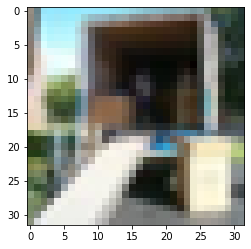

truck


In [0]:
qw=45

print(fore_idx[qw])
imshow(mosaic_list_of_images[qw][fore_idx[qw]])
# print(mosaic_list_of_images[0])
print(classes[mosaic_label[qw]+7]) # add 7 as we had subtracted 7 while saving

# imshow(mosaic_list_of_images[13][2])
# print(type(mosaic_list_of_images[1][0]))
# print(mosaic_label)

In [0]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    x = F.softmax(x,dim=1)   # alphas
    
    x1 = x[:,0]
    torch.mul(x1[:,None,None,None],z[:,0])

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])
    return y , x 
  
  def helper(self,x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x
      


In [0]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
    self.fc4 = nn.Linear(10,3)

  def forward(self,y):  #z batch of list of 9 images
    y1 = self.pool(F.relu(self.conv1(y)))
    y1 = self.pool(F.relu(self.conv2(y1)))
    y1 = y1.view(-1, 16 * 5 * 5)

    y1 = F.relu(self.fc1(y1))
    y1 = F.relu(self.fc2(y1))
    y1 = F.relu(self.fc3(y1))
    y1 = self.fc4(y1)
    return y1 


In [0]:
where_net = Module1().double()
where_net = where_net.to("cuda")
# print(net.parameters)

In [0]:
# idx = np.random.randint(0,250,10)
# train_iter = iter(train_loader)
# images,labels,_=train_iter.next()

# for i in idx:
#   imshow(where_net1(images)[i].detach().numpy())

In [0]:
what_net = Module2().double()
what_net = what_net.to("cuda")

In [0]:
# where_net.load_state_dict(torch.load("model_epoch90.pt"))
# what_net.load_state_dict(torch.load("model_epoch90.pt"))
# print(fore_net.parameters)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [0]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [62]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer_where = optim.SGD(where_net.parameters(), lr=0.01, momentum=0.9)
optimizer_what = optim.SGD(what_net.parameters(), lr=0.01, momentum=0.9)

nos_epochs = 320
every_what_epoch = 20
#---------------------------------------------
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0
argmax_more_than_half = 0
argmax_less_than_half =0
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
#-----------------------------------------------
train_loss=[]
test_loss =[]
train_acc = []
test_acc = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times
    
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  argmax_more_than_half = 0
  argmax_less_than_half =0
  
  running_loss = 0.0
  batch_correct = 0.0
  cnt=0
  total=0
  iteration = desired_num // batch



  #training data set

  if (epoch % (every_what_epoch*2) ) < every_what_epoch :
      print(epoch,"updating what_net, where_net is freezed")
  elif (epoch % (every_what_epoch*2)) > every_what_epoch :
      print(epoch,"updating where_net, what_net is freezed")
    
  for i, data in  enumerate(train_loader):
      inputs , labels , fore_idx = data
      inputs,labels = inputs.to("cuda"),labels.to("cuda") 
      # zero the parameter gradients
      
      optimizer_what.zero_grad()
      optimizer_where.zero_grad()
      
      avg_images , alphas = where_net(inputs)
      outputs = what_net(avg_images)
      
      _, predicted = torch.max(outputs.data, 1)
      

      loss = criterion(outputs, labels) 
      loss.backward() 
  
      if (epoch % (every_what_epoch*2) ) < every_what_epoch :
          optimizer_what.step()
      elif (epoch % (every_what_epoch*2)) > every_what_epoch :
          optimizer_where.step()
      batch_correct += sum(predicted == labels)
      total += len(predicted)
      running_loss += loss.item()
      if cnt % 120 == 119:    # print every 40 mini-batches
          print("--"*40)
          print("Epoch: ",epoch)
#             print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / 120))
          train_loss.append(running_loss/120)
          train_acc.append(batch_correct.item()/desired_num)
          print("total_Correct:",batch_correct.item(),"Total:",total,"train_loss",running_loss/120,"train_acc: ", batch_correct.item()/total)
          #running_loss = 0.0
      cnt=cnt+1

      if epoch % 5 == 0:
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1

  if epoch % 5 == 0:
    col1.append(epoch)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
  
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0
      argmax_more_than_half = 0
      argmax_less_than_half =0

      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
          
      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)

    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)

  elif epoch % 5 != 0  :
    with torch.no_grad():
      loss = 0.0
      correct = 0.0
      tot =0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs,labels = inputs.to("cuda"),labels.to("cuda") 
        avg_images , alphas = where_net(inputs)
        outputs = what_net(avg_images)
        _, predicted = torch.max(outputs.data, 1)
        loss += criterion(outputs, labels).item() 
        correct += sum(predicted == labels)
        tot += len(predicted)

      test_loss.append(loss/40) # 10000/250 = 40
      test_acc.append(correct.item()/tot)
      print("total_Correct:",correct.item(),"Total:",tot,"test loss: ", loss/40, "test accuracy", correct.item()/tot)
 
    
  if (epoch % (every_what_epoch*2) == every_what_epoch*2 - 1):
      torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_320epochs_every20epoch_lr_01/where_model_at_epoch"+str(epoch)+".pt")
      torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_320epochs_every20epoch_lr_01/what_model_at_epoch"+str(epoch)+".pt")
    
print('Finished Training')
torch.save(where_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_320epochs_every20epoch_lr_01/full_where_model_epoch"+str(nos_epochs)+".pt")
torch.save(what_net.state_dict(),"/content/drive/My Drive/Research/stage_wise_training/alternate_training_320epochs_every20epoch_lr_01/full_what_model_epoch"+str(nos_epochs)+".pt")

0 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  0
total_Correct: 10131.0 Total: 30000 train_loss 1.0990772301112617 train_acc:  0.3377
total_Correct: 3556.0 Total: 10000 test loss:  1.0987258551639902 test accuracy 0.3556
1 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  1
total_Correct: 10080.0 Total: 30000 train_loss 1.0985629897438194 train_acc:  0.336
total_Correct: 3334.0 Total: 10000 test loss:  1.0986086562081963 test accuracy 0.3334
2 updating what_net, where_net is freezed
--------------------------------------------------------------------------------
Epoch:  2
total_Correct: 10249.0 Total: 30000 train_loss 1.0984215287014265 train_acc:  0.34163333333333334
total_Correct: 3334.0 Total: 10000 test loss:  1.0988207555113496 test accuracy 0.3334
3 updating what_net, where_net is freezed
-------------------------------

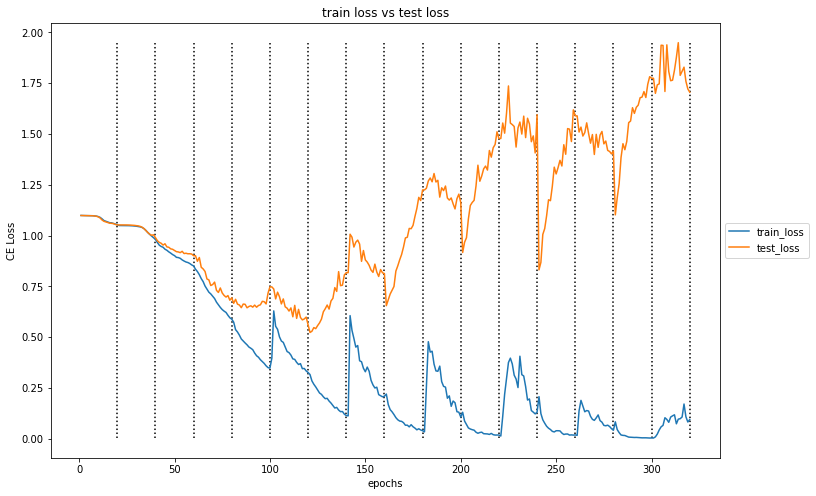

In [63]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_loss = np.random.randn(340)
# test_loss = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_loss, label='train_loss')
plt.plot(epoch_list,test_loss, label='test_loss')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("CE Loss")
plt.vlines(vline_list,min(min(train_loss),min(test_loss)), max(max(test_loss),max(train_loss)),linestyles='dotted')
plt.title("train loss vs test loss")
plt.show()
fig.savefig("train_test_loss_plot.pdf")


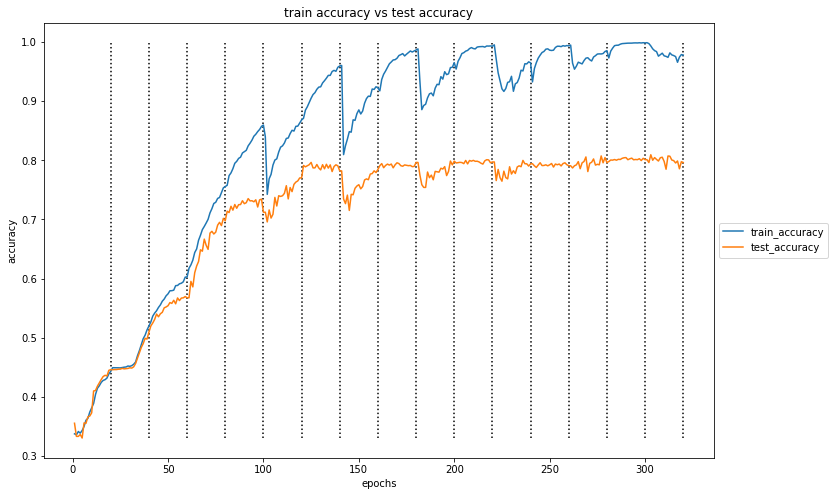

In [64]:
fig = plt.figure(figsize = (12,8) )
vline_list = np.arange(every_what_epoch, nos_epochs + every_what_epoch, every_what_epoch )
# train_acc = np.random.randn(340)
# test_acc = np.random.randn(340)
epoch_list = np.arange(1, nos_epochs+1)
plt.plot(epoch_list,train_acc, label='train_accuracy')
plt.plot(epoch_list,test_acc, label='test_accuracy')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.vlines(vline_list,min(min(train_acc),min(test_acc)), max(max(test_acc),max(train_acc)),linestyles='dotted')
plt.title("train accuracy vs test accuracy")
plt.show()
fig.savefig("train_test_acc_plot.pdf")

In [0]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ]
df_train = pd.DataFrame()
df_test = pd.DataFrame()
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13

In [66]:
df_train

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                   2593                   17276
1        5             0  ...                   2545                   16952
2       10             0  ...                   2414                   15920
3       15             0  ...                   2220                   14942
4       20             0  ...                   2139                   14378
..     ...           ...  ...                    ...                     ...
59     295         24540  ...                      0                      54
60     300         24540  ...                      0                      40
61     305         24501  ...                    126                     366
62     310         24087  ...                    178                     556
63     315         24162  ...                    183                     561

[64 rows x 7 columns]

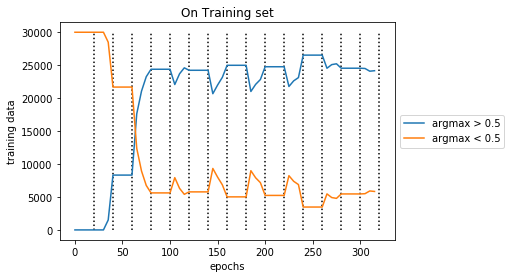

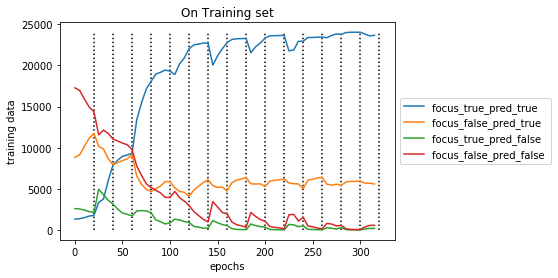

In [67]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.vlines(vline_list,min(min(col2),min(col3)), max(max(col2),max(col3)),linestyles='dotted')
plt.show()

plt.plot(col1,col4, label ="focus_true_pred_true ")
plt.plot(col1,col5, label ="focus_false_pred_true ")
plt.plot(col1,col6, label ="focus_true_pred_false ")
plt.plot(col1,col7, label ="focus_false_pred_false ")
plt.title("On Training set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.vlines(vline_list,min(min(col4),min(col5),min(col6),min(col7)), max(max(col4),max(col5),max(col6),max(col7)),linestyles='dotted')
plt.show()

In [68]:
df_test

epochs  argmax > 0.5  ...  focus_true_pred_false  focus_false_pred_false
0        0             0  ...                    846                    5598
1        5             0  ...                    837                    5602
2       10             0  ...                    761                    5138
3       15             0  ...                    722                    4933
4       20             0  ...                    707                    4832
..     ...           ...  ...                    ...                     ...
59     295          7607  ...                    494                    1496
60     300          7607  ...                    491                    1499
61     305          8363  ...                    424                    1562
62     310          6427  ...                    617                    1535
63     315          7203  ...                    522                    1524

[64 rows x 7 columns]

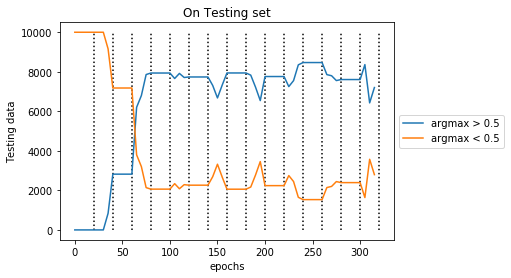

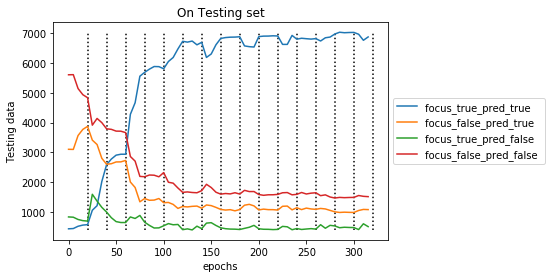

In [69]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.vlines(vline_list,min(min(col8),min(col9)), max(max(col8),max(col9)),linestyles='dotted')
plt.show()

plt.plot(col1,col10, label ="focus_true_pred_true ")
plt.plot(col1,col11, label ="focus_false_pred_true ")
plt.plot(col1,col12, label ="focus_true_pred_false ")
plt.plot(col1,col13, label ="focus_false_pred_false ")
plt.title("On Testing set")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.vlines(vline_list,min(min(col10),min(col11),min(col12),min(col13)), max(max(col10),max(col11),max(col12),max(col13)),linestyles='dotted')
plt.show()

In [70]:
print("-"*20,"Training Dataset","-"*20)
print("epochs", col1) 
print("argmax > 0.5 ", col2) 
print("argmax < 0.5 ", col3) 
print("focus_true_pred_true", col4) 
print("focus_false_pred_true", col5)
print("focus_true_pred_false", col6) 
print("focus_false_pred_false", col7) 
print("-"*20,"Testing Dataset","-"*20)
print("argmax > 0.5 ", col8)
print("argmax < 0.5", col9) 
print("focus_true_pred_true", col10) 
print("focus_false_pred_true", col11)
print("focus_true_pred_false", col12) 
print("focus_false_pred_false", col13) 

-------------------- Training Dataset --------------------
epochs [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315]
argmax > 0.5  [0, 0, 0, 0, 0, 0, 0, 1506, 8321, 8321, 8321, 8321, 8321, 17615, 21056, 23251, 24383, 24383, 24383, 24383, 24383, 22068, 23691, 24599, 24228, 24228, 24228, 24228, 24228, 20672, 21986, 23156, 24985, 24985, 24985, 24985, 24985, 21011, 22088, 22826, 24764, 24764, 24764, 24764, 24764, 21770, 22622, 23117, 26528, 26528, 26528, 26528, 26528, 24536, 25087, 25213, 24540, 24540, 24540, 24540, 24540, 24501, 24087, 24162]
argmax < 0.5  [30000, 30000, 30000, 30000, 30000, 30000, 30000, 28494, 21679, 21679, 21679, 21679, 21679, 12385, 8944, 6749, 5617, 5617, 5617, 5617, 5617, 7932, 6309, 5401, 5772, 5772, 5772, 5772, 5772, 932

In [0]:
df_train.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_320epochs_every20epoch_lr_01/focus_vs_predicted_train.csv")
df_test.to_csv("/content/drive/My Drive/Research/stage_wise_training/alternate_training_320epochs_every20epoch_lr_01/focus_vs_predicted_test.csv")

In [0]:
def display(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

****************************************************************************************************


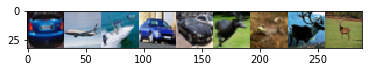

tensor([3.5951e-03, 5.2565e-03, 9.7793e-01, 1.0687e-03, 2.6811e-03, 2.2875e-04,
        2.3714e-03, 2.8786e-03, 3.9918e-03], device='cuda:0',
       dtype=torch.float64)


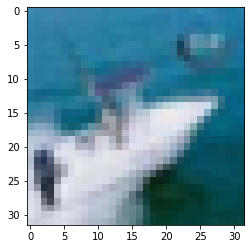

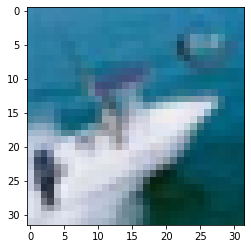

predicted ship
true ship
****************************************************************************************************


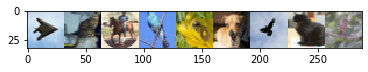

tensor([6.2317e-04, 4.5621e-03, 9.4758e-01, 6.4488e-04, 4.0623e-04, 1.2993e-03,
        3.1149e-07, 1.7875e-02, 2.7008e-02], device='cuda:0',
       dtype=torch.float64)


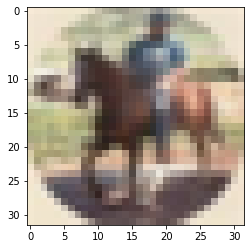

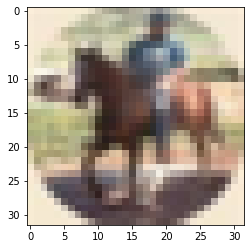

predicted horse
true horse
****************************************************************************************************


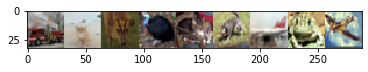

tensor([0.8252, 0.0363, 0.0290, 0.0041, 0.0233, 0.0412, 0.0252, 0.0126, 0.0031],
       device='cuda:0', dtype=torch.float64)


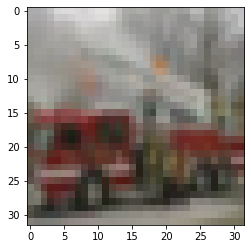

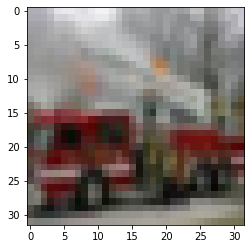

predicted truck
true truck
****************************************************************************************************


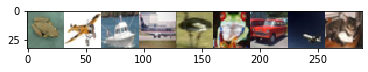

tensor([0.0560, 0.0185, 0.6662, 0.0382, 0.0240, 0.0095, 0.0059, 0.1161, 0.0656],
       device='cuda:0', dtype=torch.float64)


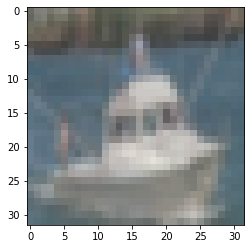

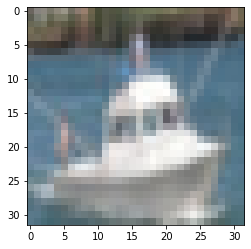

predicted ship
true ship
****************************************************************************************************


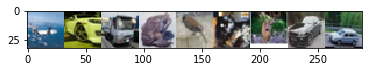

tensor([0.0767, 0.0482, 0.2711, 0.3406, 0.0524, 0.0629, 0.0479, 0.0086, 0.0916],
       device='cuda:0', dtype=torch.float64)


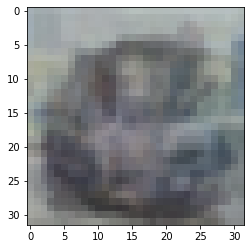

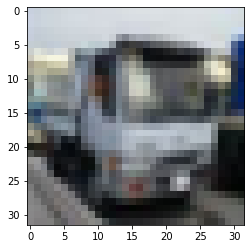

predicted truck
true truck
****************************************************************************************************


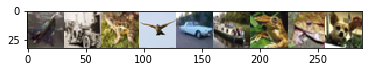

tensor([1.0741e-02, 3.1775e-01, 8.4885e-03, 1.0301e-04, 1.6441e-02, 6.3084e-01,
        1.1915e-02, 1.7931e-03, 1.9268e-03], device='cuda:0',
       dtype=torch.float64)


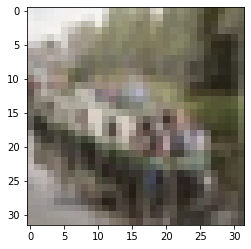

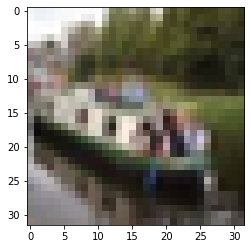

predicted ship
true ship
****************************************************************************************************


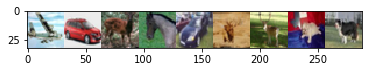

tensor([0.0247, 0.0095, 0.0562, 0.0422, 0.7612, 0.0197, 0.0321, 0.0238, 0.0305],
       device='cuda:0', dtype=torch.float64)


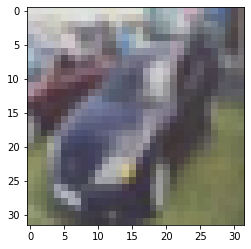

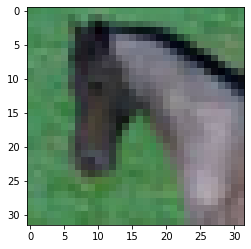

predicted horse
true horse
****************************************************************************************************


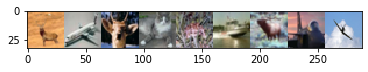

tensor([4.2862e-02, 3.9296e-03, 1.3368e-03, 1.8150e-02, 2.3815e-02, 7.2128e-01,
        1.1379e-01, 7.4568e-02, 2.7167e-04], device='cuda:0',
       dtype=torch.float64)


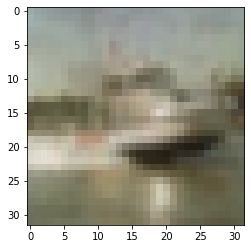

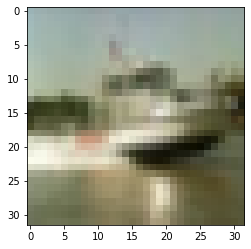

predicted ship
true ship
****************************************************************************************************


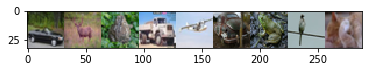

tensor([0.0022, 0.0196, 0.0153, 0.8170, 0.0029, 0.0654, 0.0036, 0.0556, 0.0184],
       device='cuda:0', dtype=torch.float64)


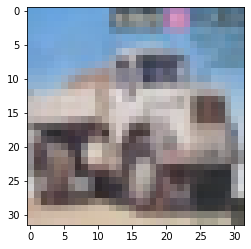

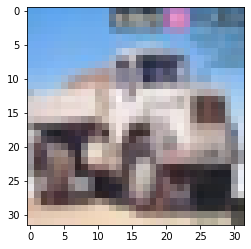

predicted truck
true truck
****************************************************************************************************


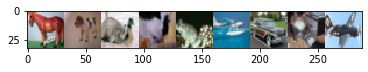

tensor([0.8597, 0.0038, 0.0115, 0.0032, 0.0109, 0.0913, 0.0056, 0.0130, 0.0009],
       device='cuda:0', dtype=torch.float64)


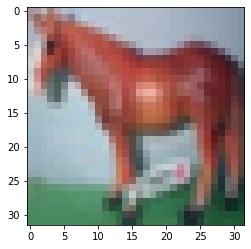

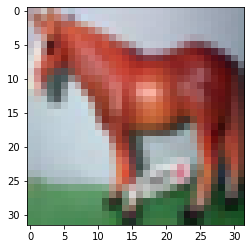

predicted horse
true horse
****************************************************************************************************


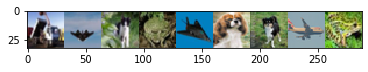

tensor([9.9467e-01, 1.3358e-03, 8.6979e-04, 1.1512e-04, 3.2161e-04, 1.7348e-04,
        5.6390e-04, 1.9092e-03, 3.9028e-05], device='cuda:0',
       dtype=torch.float64)


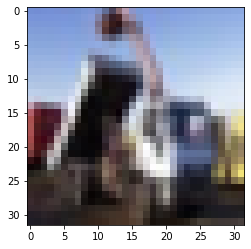

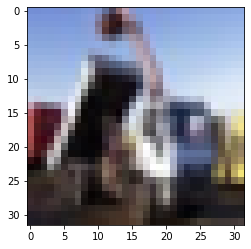

predicted truck
true truck
****************************************************************************************************


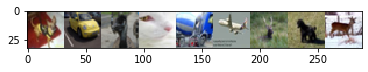

tensor([8.7702e-04, 6.6393e-03, 6.9069e-03, 2.3702e-02, 9.2749e-01, 1.4491e-02,
        1.0287e-02, 2.6173e-03, 6.9886e-03], device='cuda:0',
       dtype=torch.float64)


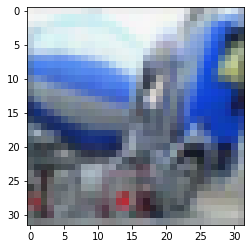

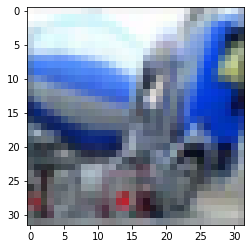

predicted truck
true truck
****************************************************************************************************


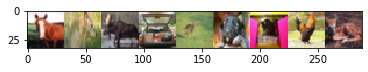

tensor([0.0573, 0.0408, 0.0808, 0.5145, 0.0255, 0.1084, 0.0670, 0.0023, 0.1033],
       device='cuda:0', dtype=torch.float64)


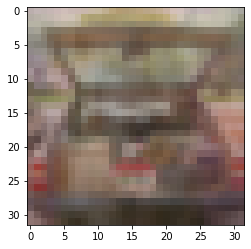

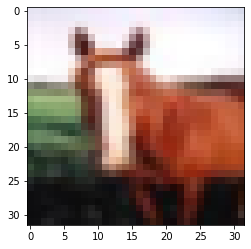

predicted horse
true horse
****************************************************************************************************


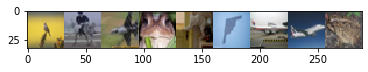

tensor([0.0703, 0.4710, 0.0964, 0.0495, 0.0966, 0.0084, 0.0944, 0.0377, 0.0757],
       device='cuda:0', dtype=torch.float64)


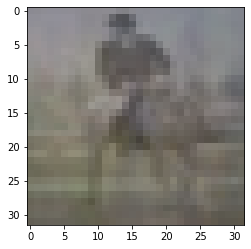

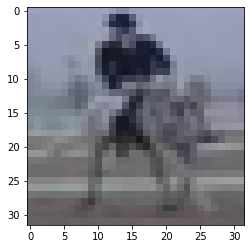

predicted horse
true horse
****************************************************************************************************


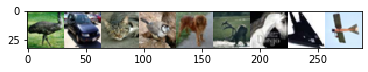

tensor([0.0058, 0.0183, 0.0242, 0.1756, 0.7435, 0.0122, 0.0094, 0.0096, 0.0014],
       device='cuda:0', dtype=torch.float64)


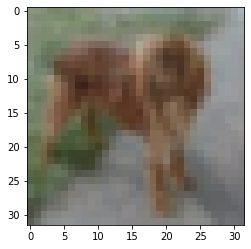

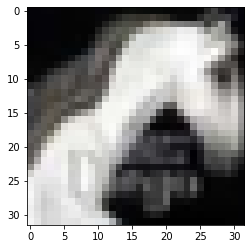

predicted horse
true horse
****************************************************************************************************


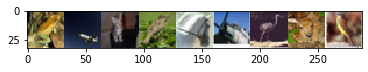

tensor([0.0979, 0.2294, 0.0956, 0.0307, 0.1215, 0.0730, 0.0965, 0.1034, 0.1523],
       device='cuda:0', dtype=torch.float64)


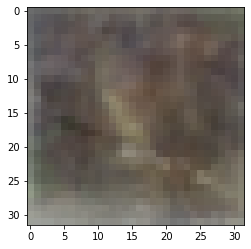

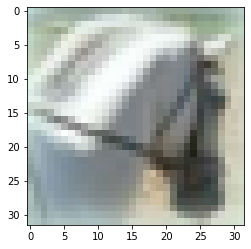

predicted horse
true horse
****************************************************************************************************


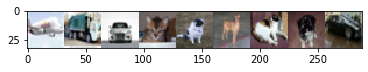

tensor([1.3908e-02, 8.9730e-01, 3.9845e-04, 1.3263e-02, 1.3744e-03, 2.3721e-02,
        2.1246e-02, 2.2309e-03, 2.6561e-02], device='cuda:0',
       dtype=torch.float64)


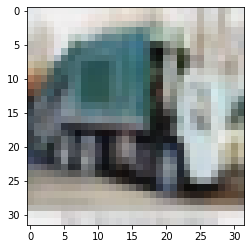

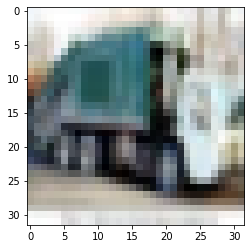

predicted truck
true truck
****************************************************************************************************


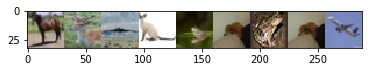

tensor([9.9854e-01, 5.8522e-05, 2.2785e-04, 4.7374e-04, 1.3501e-04, 2.5132e-04,
        1.3132e-05, 2.5132e-04, 4.7486e-05], device='cuda:0',
       dtype=torch.float64)


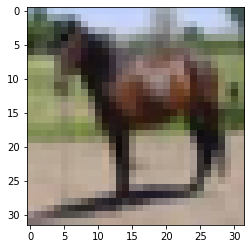

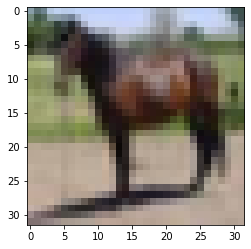

predicted horse
true horse
****************************************************************************************************


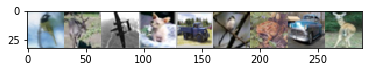

tensor([0.0012, 0.0173, 0.0138, 0.0038, 0.6494, 0.0008, 0.0132, 0.2824, 0.0182],
       device='cuda:0', dtype=torch.float64)


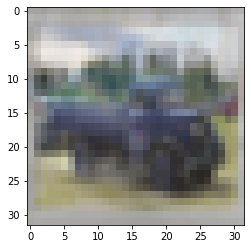

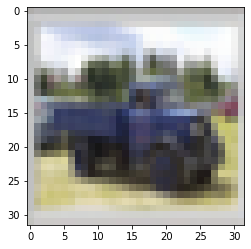

predicted truck
true truck
****************************************************************************************************


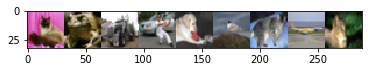

tensor([0.0237, 0.0084, 0.7273, 0.0360, 0.0303, 0.0629, 0.0051, 0.1043, 0.0020],
       device='cuda:0', dtype=torch.float64)


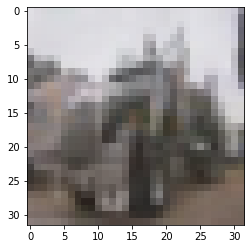

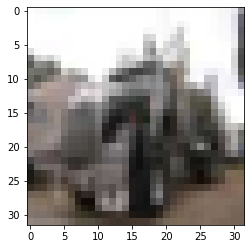

predicted truck
true truck
****************************************************************************************************


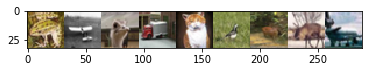

tensor([0.0047, 0.5373, 0.0468, 0.3180, 0.0009, 0.0049, 0.0586, 0.0136, 0.0153],
       device='cuda:0', dtype=torch.float64)


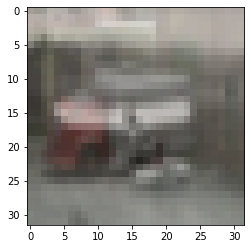

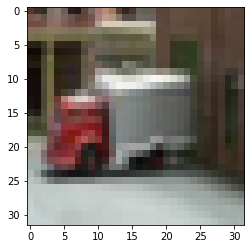

predicted truck
true truck
****************************************************************************************************


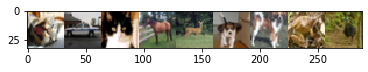

tensor([0.0126, 0.3787, 0.0028, 0.5382, 0.0296, 0.0153, 0.0106, 0.0096, 0.0026],
       device='cuda:0', dtype=torch.float64)


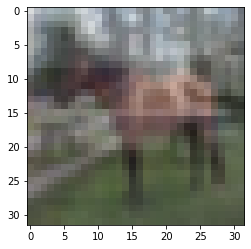

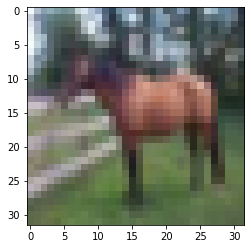

predicted horse
true horse
****************************************************************************************************


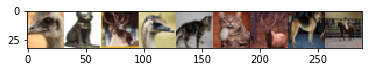

tensor([0.0171, 0.0332, 0.0207, 0.0182, 0.0217, 0.0230, 0.0111, 0.0484, 0.8065],
       device='cuda:0', dtype=torch.float64)


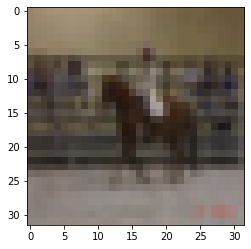

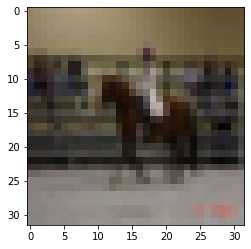

predicted horse
true horse
****************************************************************************************************


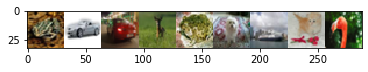

tensor([0.0016, 0.0094, 0.0038, 0.0057, 0.0023, 0.0122, 0.9567, 0.0032, 0.0051],
       device='cuda:0', dtype=torch.float64)


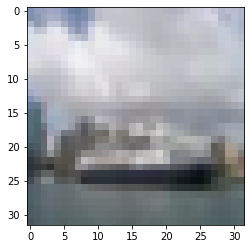

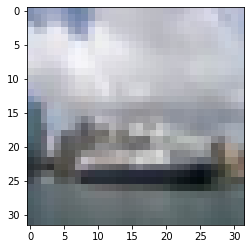

predicted ship
true ship
****************************************************************************************************


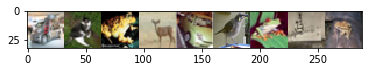

tensor([0.0642, 0.1162, 0.0032, 0.0613, 0.0164, 0.0056, 0.0275, 0.5054, 0.2004],
       device='cuda:0', dtype=torch.float64)


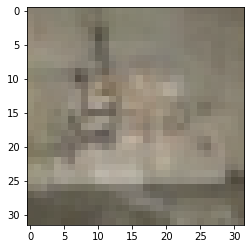

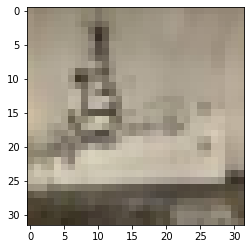

predicted ship
true ship
****************************************************************************************************


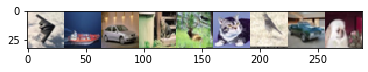

tensor([0.0040, 0.9027, 0.0016, 0.0157, 0.0041, 0.0172, 0.0086, 0.0074, 0.0387],
       device='cuda:0', dtype=torch.float64)


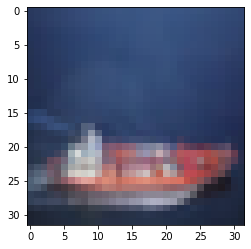

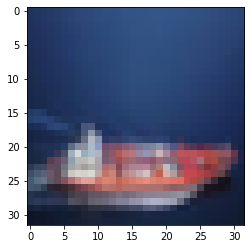

predicted ship
true ship
****************************************************************************************************


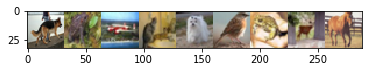

tensor([0.0166, 0.0333, 0.0481, 0.0099, 0.0699, 0.0096, 0.0024, 0.0318, 0.7783],
       device='cuda:0', dtype=torch.float64)


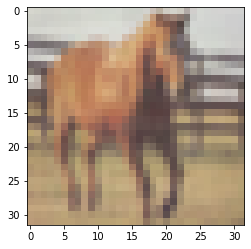

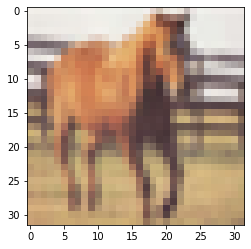

predicted horse
true horse
****************************************************************************************************


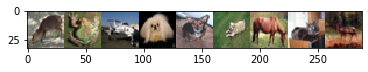

tensor([1.3093e-03, 3.7330e-04, 1.2991e-02, 1.6112e-02, 8.5200e-03, 8.8126e-03,
        9.4274e-01, 4.5185e-03, 4.6281e-03], device='cuda:0',
       dtype=torch.float64)


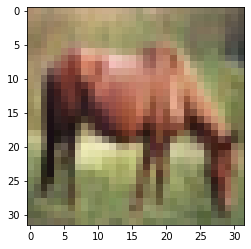

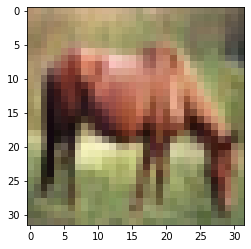

predicted horse
true horse
****************************************************************************************************


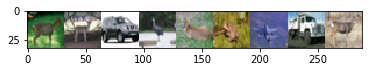

tensor([0.0387, 0.0051, 0.0048, 0.0138, 0.0223, 0.0015, 0.0158, 0.8779, 0.0201],
       device='cuda:0', dtype=torch.float64)


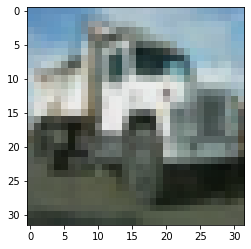

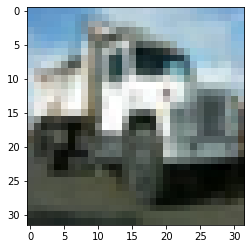

predicted truck
true truck
****************************************************************************************************


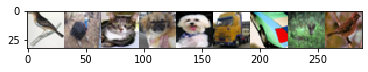

tensor([0.0010, 0.0069, 0.3319, 0.0125, 0.0123, 0.5595, 0.0078, 0.0516, 0.0164],
       device='cuda:0', dtype=torch.float64)


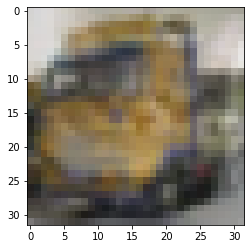

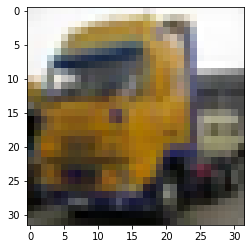

predicted truck
true truck
****************************************************************************************************


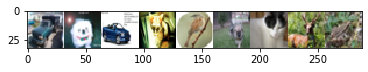

tensor([0.6972, 0.0513, 0.0067, 0.0031, 0.0257, 0.1730, 0.0034, 0.0034, 0.0362],
       device='cuda:0', dtype=torch.float64)


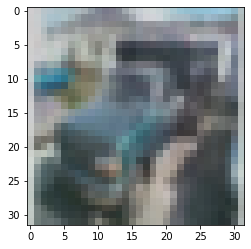

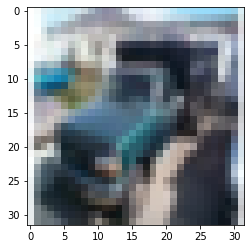

predicted truck
true truck
****************************************************************************************************


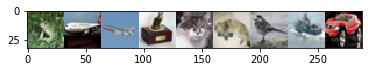

tensor([0.0033, 0.1618, 0.0186, 0.1185, 0.1774, 0.0238, 0.1278, 0.3335, 0.0353],
       device='cuda:0', dtype=torch.float64)


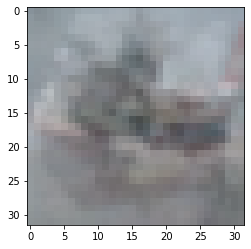

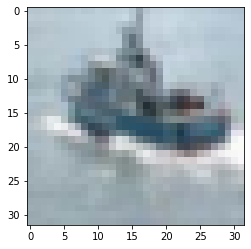

predicted ship
true ship
****************************************************************************************************


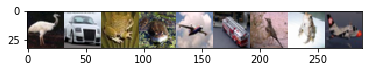

tensor([0.0636, 0.0657, 0.0435, 0.3559, 0.0918, 0.0560, 0.0419, 0.1018, 0.1798],
       device='cuda:0', dtype=torch.float64)


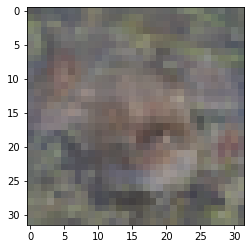

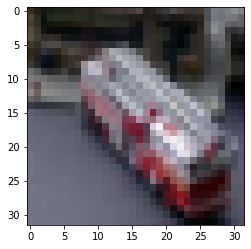

predicted truck
true truck
****************************************************************************************************


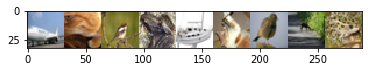

tensor([9.4965e-01, 2.7107e-03, 1.2476e-03, 1.6792e-02, 7.0029e-03, 1.9909e-03,
        3.4511e-03, 1.6825e-02, 3.2569e-04], device='cuda:0',
       dtype=torch.float64)


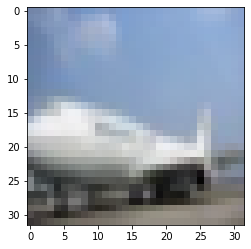

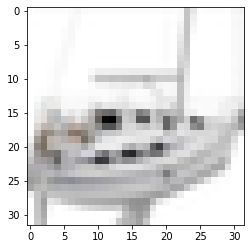

predicted horse
true ship
****************************************************************************************************


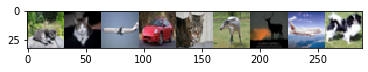

tensor([0.0038, 0.0127, 0.0017, 0.0126, 0.0984, 0.8078, 0.0374, 0.0089, 0.0168],
       device='cuda:0', dtype=torch.float64)


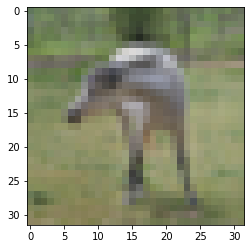

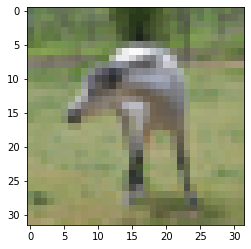

predicted horse
true horse
****************************************************************************************************


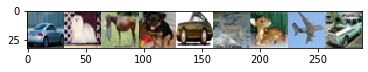

tensor([8.0999e-03, 9.1770e-03, 9.2553e-01, 9.0233e-03, 7.4062e-03, 6.8088e-03,
        2.9462e-02, 4.0336e-03, 4.6454e-04], device='cuda:0',
       dtype=torch.float64)


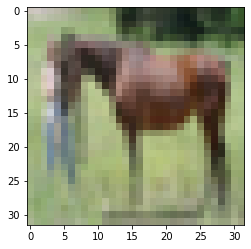

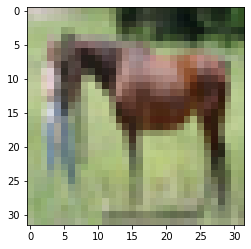

predicted horse
true horse
****************************************************************************************************


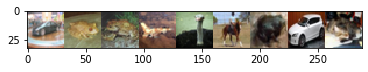

tensor([3.6535e-01, 3.2158e-02, 6.3309e-02, 6.4229e-02, 4.6456e-03, 3.9632e-01,
        6.3588e-02, 1.0422e-04, 1.0293e-02], device='cuda:0',
       dtype=torch.float64)


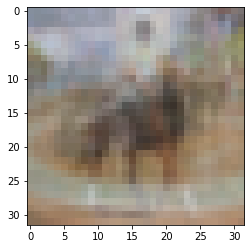

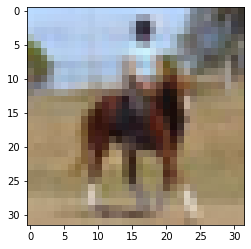

predicted horse
true horse
****************************************************************************************************


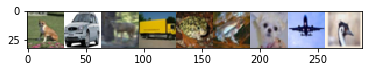

tensor([0.0424, 0.0090, 0.2205, 0.4545, 0.0200, 0.0666, 0.0542, 0.0027, 0.1301],
       device='cuda:0', dtype=torch.float64)


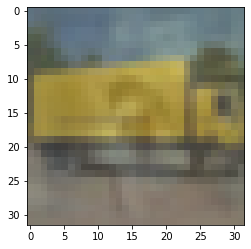

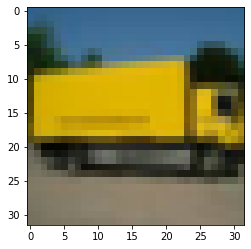

predicted horse
true truck
****************************************************************************************************


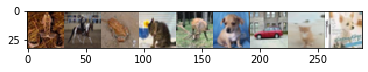

tensor([0.0369, 0.5931, 0.0625, 0.0350, 0.0419, 0.0288, 0.0030, 0.0714, 0.1273],
       device='cuda:0', dtype=torch.float64)


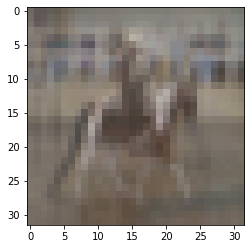

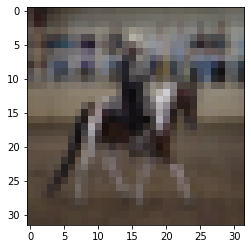

predicted horse
true horse
****************************************************************************************************


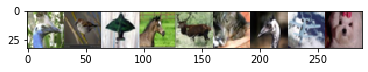

tensor([5.9828e-02, 5.0700e-02, 1.9665e-05, 7.5743e-02, 1.0586e-01, 6.1483e-02,
        5.4367e-01, 3.3437e-02, 6.9260e-02], device='cuda:0',
       dtype=torch.float64)


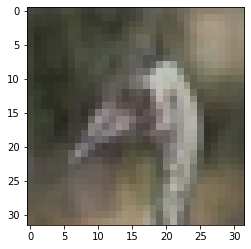

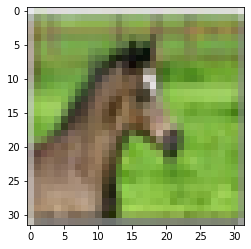

predicted horse
true horse
****************************************************************************************************


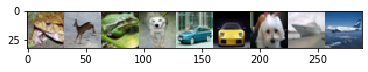

tensor([0.0172, 0.1164, 0.1726, 0.0298, 0.0358, 0.0473, 0.1661, 0.2667, 0.1481],
       device='cuda:0', dtype=torch.float64)


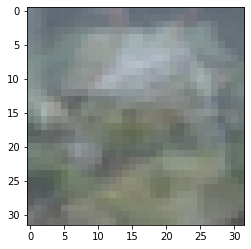

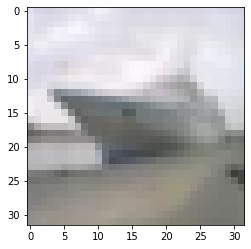

predicted ship
true ship
****************************************************************************************************


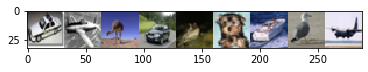

tensor([0.0026, 0.0292, 0.0099, 0.0056, 0.0375, 0.0419, 0.8409, 0.0165, 0.0160],
       device='cuda:0', dtype=torch.float64)


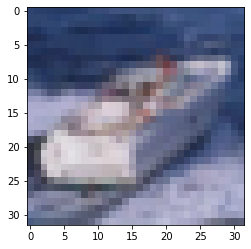

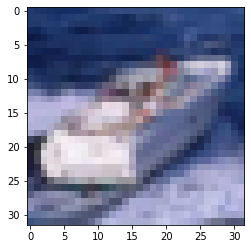

predicted ship
true ship
****************************************************************************************************


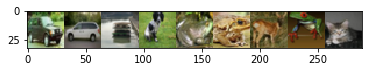

tensor([0.0152, 0.0042, 0.2709, 0.1035, 0.0155, 0.0342, 0.0905, 0.1974, 0.2685],
       device='cuda:0', dtype=torch.float64)


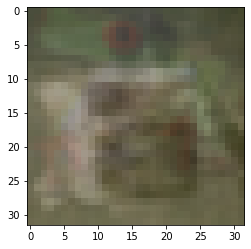

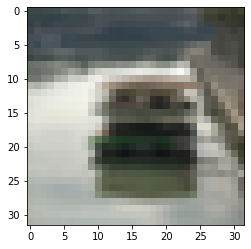

predicted ship
true ship
****************************************************************************************************


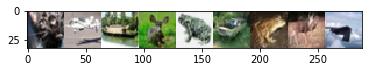

tensor([0.0862, 0.7671, 0.0252, 0.0066, 0.0420, 0.0259, 0.0043, 0.0327, 0.0100],
       device='cuda:0', dtype=torch.float64)


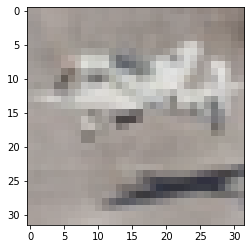

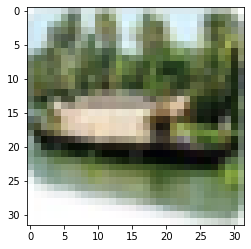

predicted ship
true ship
****************************************************************************************************


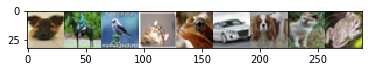

tensor([0.0536, 0.5452, 0.0101, 0.2721, 0.0101, 0.0017, 0.0658, 0.0279, 0.0136],
       device='cuda:0', dtype=torch.float64)


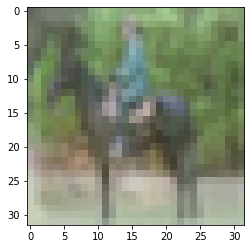

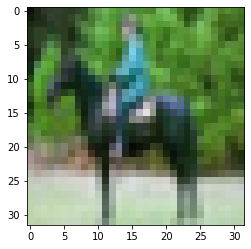

predicted horse
true horse
****************************************************************************************************


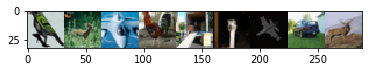

tensor([2.9573e-02, 2.4191e-02, 4.6085e-02, 2.7346e-01, 3.0535e-02, 3.1585e-04,
        5.9624e-02, 4.5716e-01, 7.9060e-02], device='cuda:0',
       dtype=torch.float64)


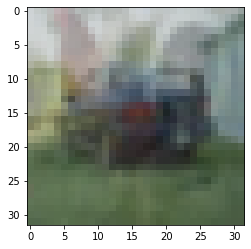

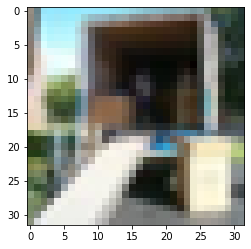

predicted truck
true truck
****************************************************************************************************


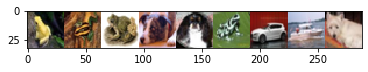

tensor([6.3842e-03, 2.4712e-02, 6.0132e-02, 3.9129e-03, 5.8556e-04, 4.8241e-02,
        1.4248e-02, 8.2334e-01, 1.8440e-02], device='cuda:0',
       dtype=torch.float64)


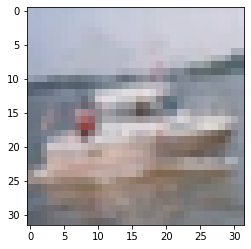

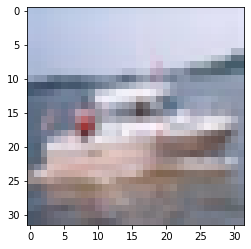

predicted ship
true ship
****************************************************************************************************


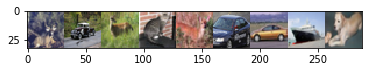

tensor([2.1924e-03, 2.0766e-04, 2.5514e-04, 2.3575e-04, 2.4949e-04, 1.3508e-04,
        4.8974e-04, 9.9592e-01, 3.1160e-04], device='cuda:0',
       dtype=torch.float64)


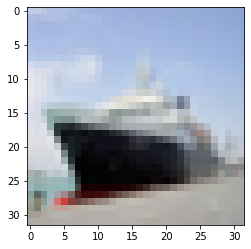

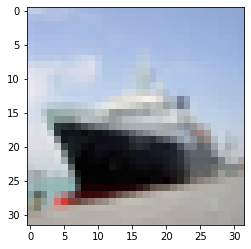

predicted ship
true ship
****************************************************************************************************


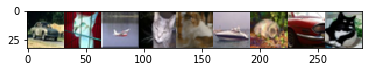

tensor([9.4538e-05, 2.8365e-05, 2.9379e-05, 4.5831e-06, 3.4036e-05, 9.9952e-01,
        2.0553e-05, 2.6370e-04, 1.4635e-06], device='cuda:0',
       dtype=torch.float64)


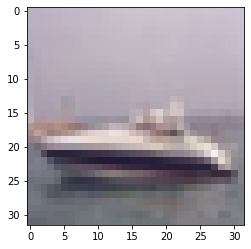

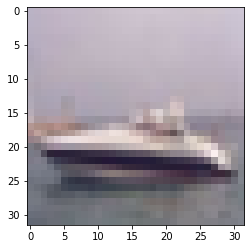

predicted ship
true ship
****************************************************************************************************


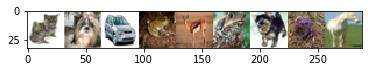

tensor([0.1463, 0.0039, 0.0172, 0.0087, 0.0049, 0.1415, 0.0461, 0.0138, 0.6176],
       device='cuda:0', dtype=torch.float64)


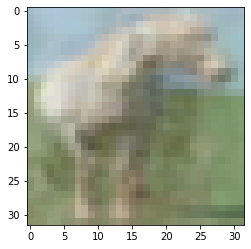

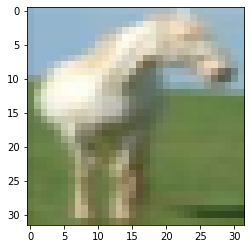

predicted horse
true horse
Accuracy of the network on the 30000 train images: 97 %
total correct 29238
total train set images 30000
focus_true_pred_true 38
focus_false_pred_true 10
focus_true_pred_false 1
focus_false_pred_false 1
argmax_more_than_half 40
argmax_less_than_half 10


In [73]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])
        
        focus = torch.argmax(alphas[j])
      
        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1

      flag =0

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

In [0]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
    bg_idx = np.random.randint(0,35000,8)
    fg_idx = np.random.randint(0,15000)
    fg = np.random.randint(0,9)
    fore_idx_test.append(fg)
    image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
    test_images.append(image_list)
    test_label.append(label)

In [0]:
# test_data = MosaicDataset(test_images,test_label,)
# test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

7


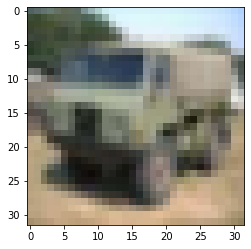

truck


In [76]:
print(fore_idx_test[0])
imshow(test_images[0][fore_idx_test[0]])
print(classes[test_label[0]+7])

****************************************************************************************************


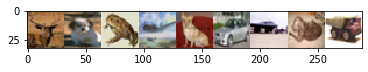

tensor([0.0027, 0.0053, 0.0181, 0.0266, 0.0051, 0.0093, 0.0105, 0.0350, 0.8874],
       device='cuda:0', dtype=torch.float64)


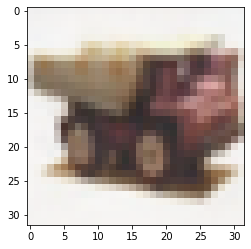

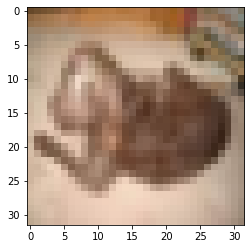

predicted truck
true truck
****************************************************************************************************


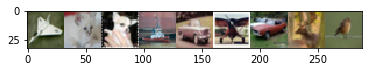

tensor([0.3416, 0.0179, 0.0218, 0.3515, 0.0092, 0.1747, 0.0321, 0.0290, 0.0221],
       device='cuda:0', dtype=torch.float64)


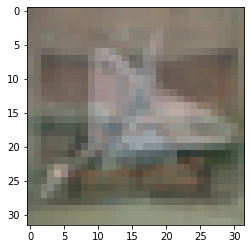

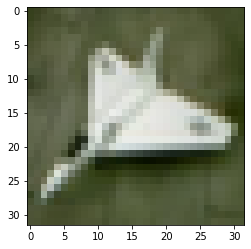

predicted truck
true ship
****************************************************************************************************


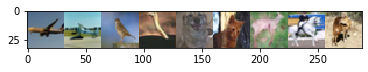

tensor([0.0005, 0.2569, 0.0117, 0.1489, 0.0424, 0.0224, 0.0412, 0.4666, 0.0093],
       device='cuda:0', dtype=torch.float64)


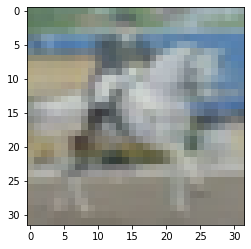

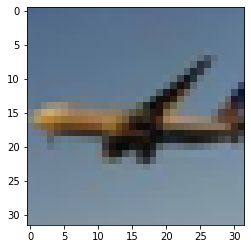

predicted horse
true horse
****************************************************************************************************


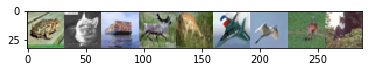

tensor([1.5392e-03, 1.1261e-03, 9.7298e-01, 3.0215e-03, 2.9603e-03, 4.4549e-03,
        1.5536e-03, 6.6432e-04, 1.1704e-02], device='cuda:0',
       dtype=torch.float64)


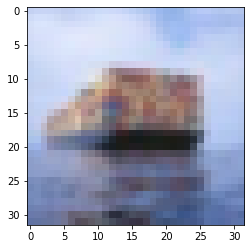

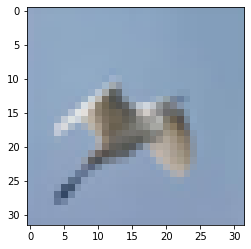

predicted ship
true ship
****************************************************************************************************


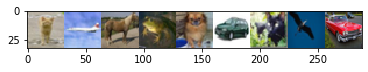

tensor([1.5054e-02, 1.6751e-03, 8.4473e-01, 1.5012e-02, 3.5393e-03, 2.1516e-02,
        7.8488e-02, 1.9762e-02, 2.2203e-04], device='cuda:0',
       dtype=torch.float64)


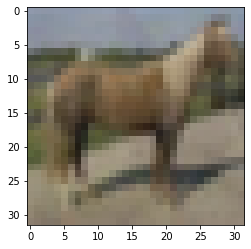

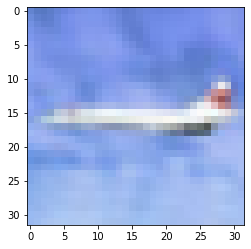

predicted horse
true horse
****************************************************************************************************


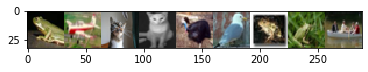

tensor([0.0223, 0.0290, 0.1016, 0.2218, 0.1453, 0.3301, 0.0107, 0.0141, 0.1250],
       device='cuda:0', dtype=torch.float64)


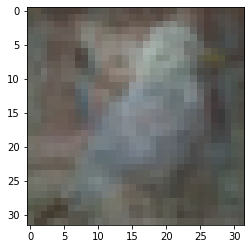

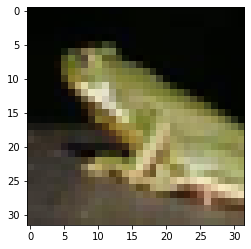

predicted truck
true ship
****************************************************************************************************


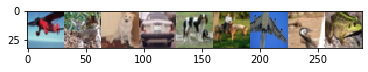

tensor([0.1677, 0.0979, 0.0619, 0.1792, 0.1070, 0.2047, 0.0328, 0.1284, 0.0205],
       device='cuda:0', dtype=torch.float64)


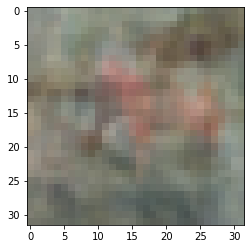

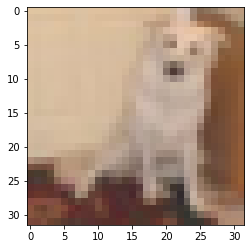

predicted truck
true horse
****************************************************************************************************


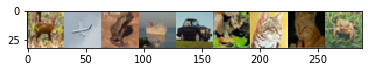

tensor([0.0399, 0.0306, 0.0578, 0.3716, 0.3566, 0.0498, 0.0386, 0.0030, 0.0520],
       device='cuda:0', dtype=torch.float64)


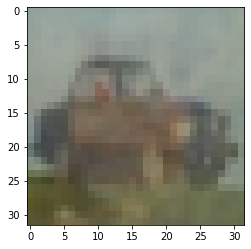

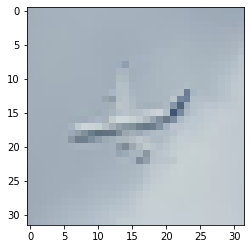

predicted horse
true ship
****************************************************************************************************


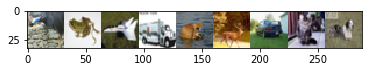

tensor([0.0210, 0.0056, 0.0014, 0.8073, 0.0084, 0.0063, 0.1112, 0.0105, 0.0284],
       device='cuda:0', dtype=torch.float64)


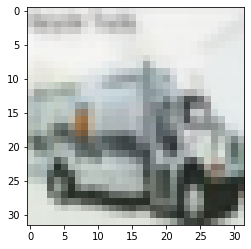

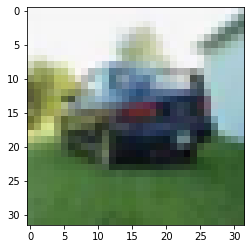

predicted truck
true truck
****************************************************************************************************


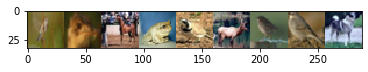

tensor([0.0085, 0.0144, 0.7904, 0.0134, 0.0044, 0.0058, 0.0276, 0.0110, 0.1247],
       device='cuda:0', dtype=torch.float64)


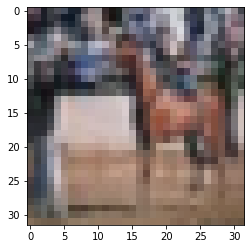

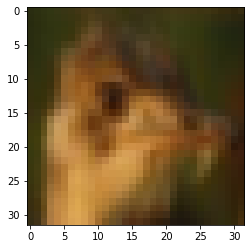

predicted horse
true horse
****************************************************************************************************


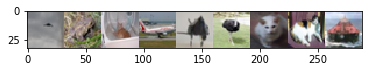

tensor([0.0035, 0.0046, 0.0024, 0.0021, 0.0059, 0.0021, 0.0038, 0.0045, 0.9711],
       device='cuda:0', dtype=torch.float64)


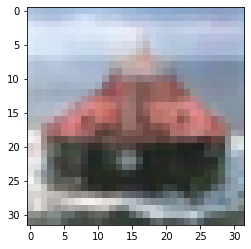

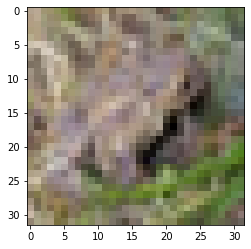

predicted ship
true ship
****************************************************************************************************


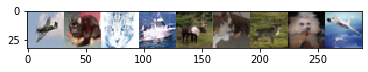

tensor([2.9578e-05, 2.9750e-04, 6.1143e-05, 9.9508e-01, 5.1875e-04, 8.7902e-04,
        6.5779e-04, 1.5371e-03, 9.4246e-04], device='cuda:0',
       dtype=torch.float64)


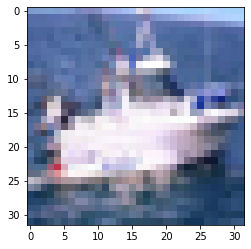

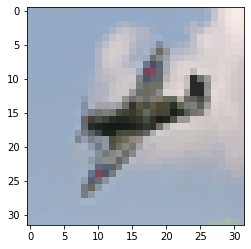

predicted ship
true ship
****************************************************************************************************


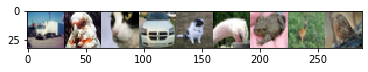

tensor([9.7841e-01, 1.0920e-03, 3.6594e-04, 2.0331e-03, 6.5273e-04, 1.1057e-02,
        5.7472e-04, 4.6917e-03, 1.1204e-03], device='cuda:0',
       dtype=torch.float64)


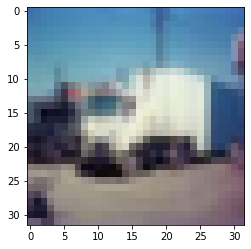

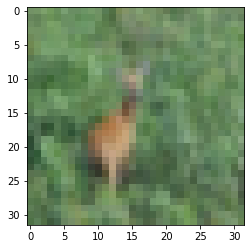

predicted truck
true truck
****************************************************************************************************


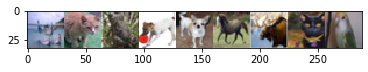

tensor([2.6144e-03, 4.6374e-04, 6.0331e-04, 1.2807e-03, 1.2950e-04, 9.9316e-01,
        4.6856e-04, 1.8408e-04, 1.0979e-03], device='cuda:0',
       dtype=torch.float64)


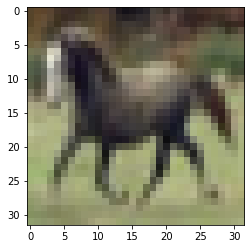

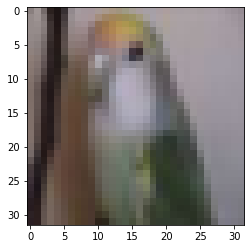

predicted horse
true horse
****************************************************************************************************


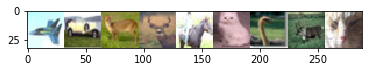

tensor([0.0439, 0.2186, 0.0761, 0.2096, 0.2425, 0.0659, 0.0950, 0.0416, 0.0067],
       device='cuda:0', dtype=torch.float64)


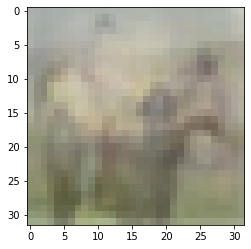

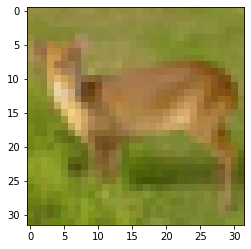

predicted ship
true horse
****************************************************************************************************


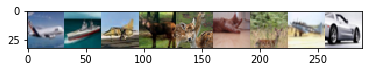

tensor([3.4617e-05, 8.0537e-01, 6.7456e-04, 9.8256e-04, 1.2349e-03, 1.4914e-03,
        1.9544e-04, 2.1458e-03, 1.8787e-01], device='cuda:0',
       dtype=torch.float64)


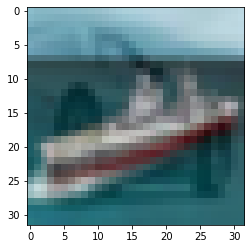

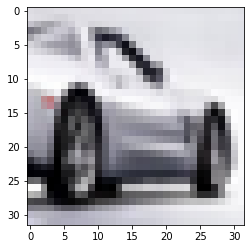

predicted ship
true ship
****************************************************************************************************


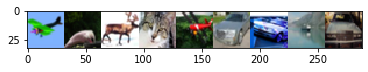

tensor([0.0009, 0.0625, 0.0085, 0.1130, 0.0806, 0.4842, 0.0516, 0.1676, 0.0311],
       device='cuda:0', dtype=torch.float64)


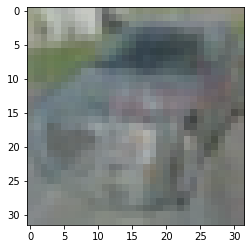

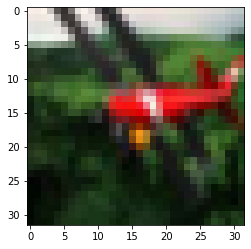

predicted truck
true ship
****************************************************************************************************


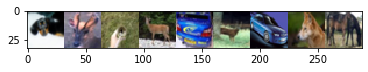

tensor([5.1968e-04, 3.4270e-04, 2.6660e-04, 3.4182e-04, 7.8244e-05, 6.7877e-05,
        3.5609e-05, 2.3899e-05, 9.9832e-01], device='cuda:0',
       dtype=torch.float64)


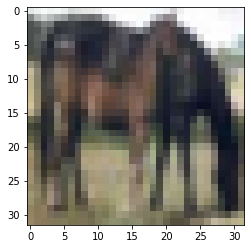

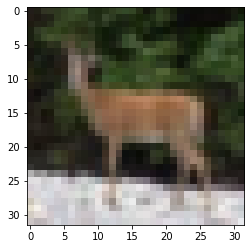

predicted horse
true horse
****************************************************************************************************


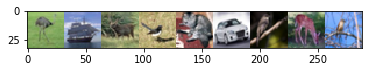

tensor([4.4511e-05, 9.9881e-01, 2.7914e-04, 1.5209e-04, 3.7980e-04, 1.9357e-05,
        7.1948e-05, 2.4270e-04, 5.1972e-06], device='cuda:0',
       dtype=torch.float64)


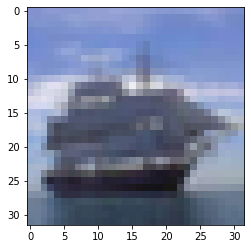

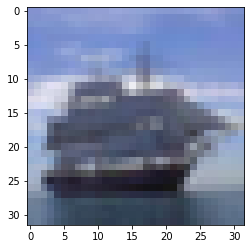

predicted ship
true ship
****************************************************************************************************


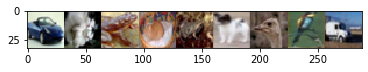

tensor([0.0130, 0.0061, 0.0425, 0.0668, 0.0681, 0.0592, 0.0326, 0.0551, 0.6567],
       device='cuda:0', dtype=torch.float64)


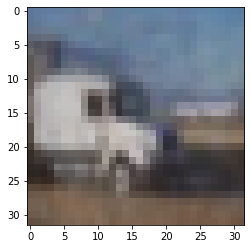

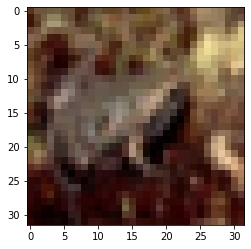

predicted truck
true truck
****************************************************************************************************


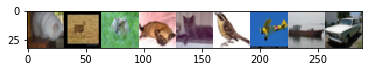

tensor([5.3072e-03, 3.9507e-03, 3.5454e-03, 3.1762e-03, 6.2902e-02, 9.7571e-04,
        7.2226e-06, 9.1064e-01, 9.4925e-03], device='cuda:0',
       dtype=torch.float64)


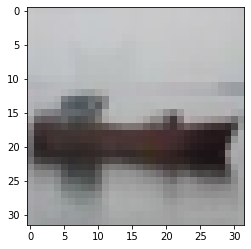

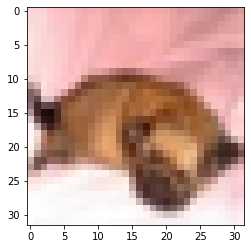

predicted ship
true ship
****************************************************************************************************


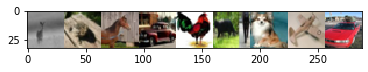

tensor([0.1189, 0.0605, 0.0095, 0.1568, 0.0246, 0.3834, 0.0624, 0.1405, 0.0435],
       device='cuda:0', dtype=torch.float64)


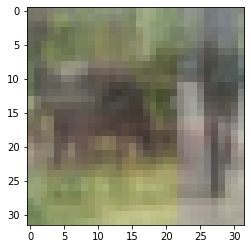

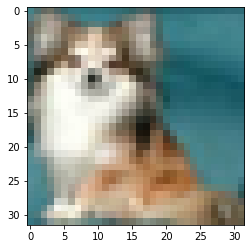

predicted horse
true horse
****************************************************************************************************


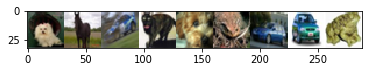

tensor([0.1190, 0.2729, 0.1992, 0.0645, 0.0400, 0.1494, 0.0757, 0.0218, 0.0575],
       device='cuda:0', dtype=torch.float64)


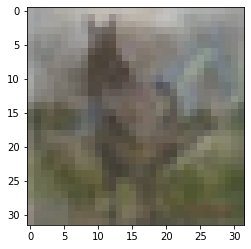

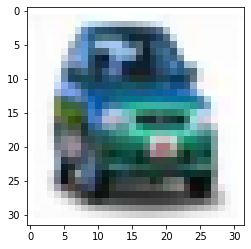

predicted horse
true horse
****************************************************************************************************


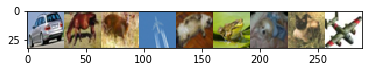

tensor([0.0028, 0.8833, 0.0240, 0.0030, 0.0100, 0.0056, 0.0440, 0.0264, 0.0009],
       device='cuda:0', dtype=torch.float64)


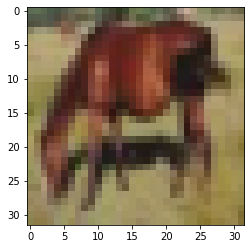

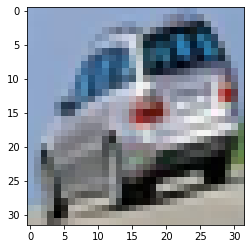

predicted horse
true horse
****************************************************************************************************


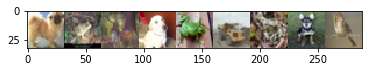

tensor([0.1015, 0.1216, 0.0625, 0.0124, 0.0401, 0.5616, 0.0407, 0.0186, 0.0410],
       device='cuda:0', dtype=torch.float64)


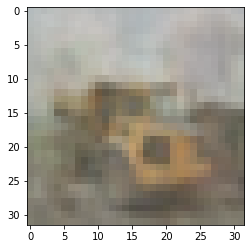

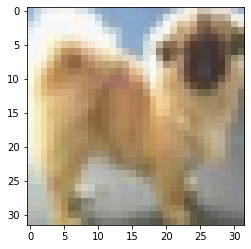

predicted truck
true truck
****************************************************************************************************


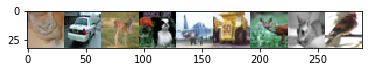

tensor([0.0621, 0.0642, 0.1111, 0.0109, 0.0152, 0.2266, 0.3444, 0.1212, 0.0442],
       device='cuda:0', dtype=torch.float64)


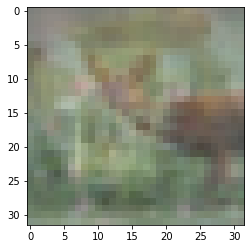

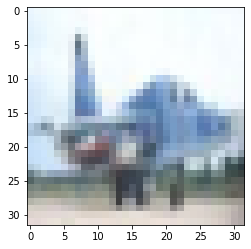

predicted truck
true truck
****************************************************************************************************


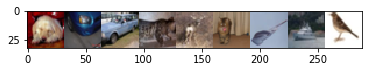

tensor([0.0526, 0.1200, 0.0152, 0.1142, 0.1148, 0.3732, 0.0591, 0.1487, 0.0023],
       device='cuda:0', dtype=torch.float64)


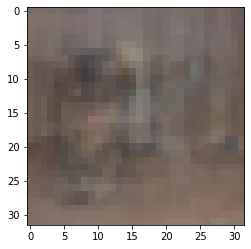

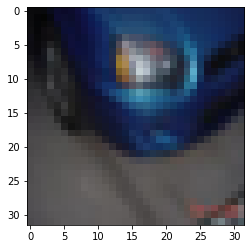

predicted horse
true ship
****************************************************************************************************


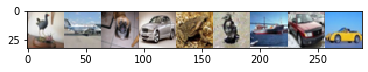

tensor([0.0039, 0.0131, 0.0014, 0.0025, 0.0045, 0.0055, 0.9505, 0.0117, 0.0070],
       device='cuda:0', dtype=torch.float64)


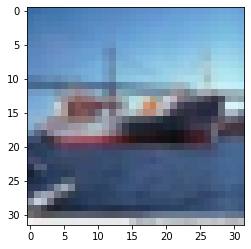

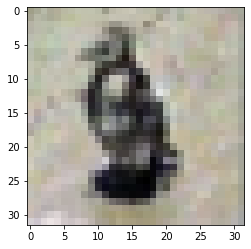

predicted ship
true ship
****************************************************************************************************


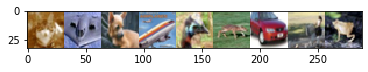

tensor([0.0096, 0.0070, 0.0415, 0.0052, 0.0740, 0.0605, 0.0058, 0.0834, 0.7130],
       device='cuda:0', dtype=torch.float64)


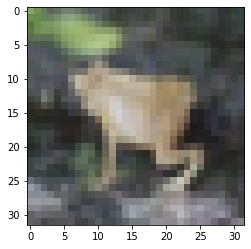

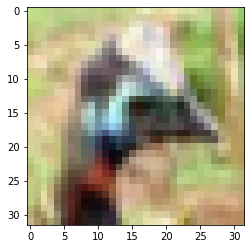

predicted horse
true horse
****************************************************************************************************


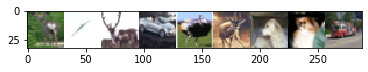

tensor([0.0224, 0.0475, 0.0805, 0.1527, 0.5959, 0.0470, 0.0150, 0.0063, 0.0327],
       device='cuda:0', dtype=torch.float64)


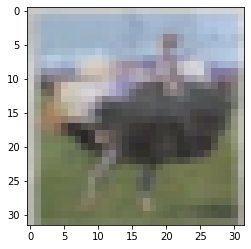

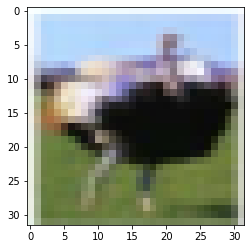

predicted truck
true truck
****************************************************************************************************


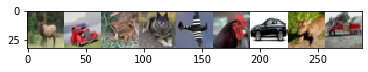

tensor([4.7664e-04, 4.7818e-03, 1.1454e-03, 7.8039e-04, 5.2741e-04, 1.5018e-05,
        1.2412e-03, 3.8987e-04, 9.9064e-01], device='cuda:0',
       dtype=torch.float64)


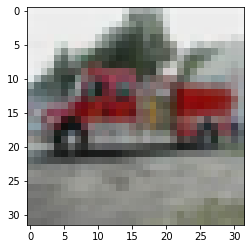

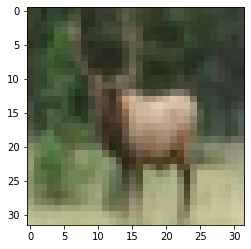

predicted truck
true truck
****************************************************************************************************


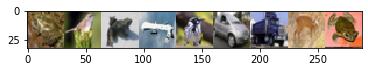

tensor([0.0046, 0.0106, 0.0045, 0.0069, 0.0029, 0.0021, 0.9481, 0.0099, 0.0103],
       device='cuda:0', dtype=torch.float64)


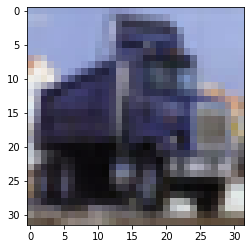

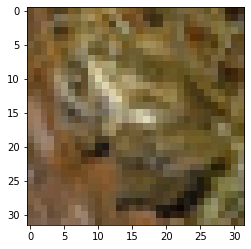

predicted truck
true truck
****************************************************************************************************


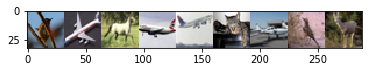

tensor([1.1863e-04, 7.2278e-05, 9.9674e-01, 2.3003e-05, 4.2379e-04, 4.7087e-04,
        1.9555e-03, 3.6758e-05, 1.6338e-04], device='cuda:0',
       dtype=torch.float64)


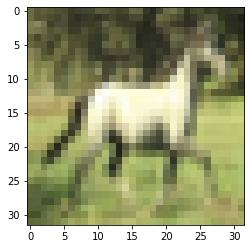

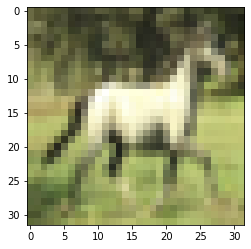

predicted horse
true horse
****************************************************************************************************


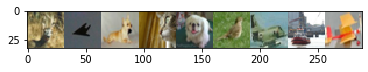

tensor([0.0759, 0.0142, 0.0302, 0.0135, 0.2396, 0.0156, 0.0592, 0.4753, 0.0766],
       device='cuda:0', dtype=torch.float64)


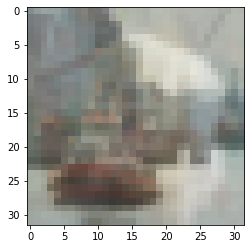

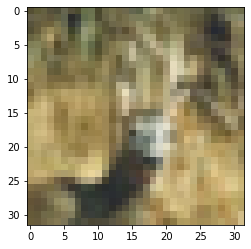

predicted truck
true ship
****************************************************************************************************


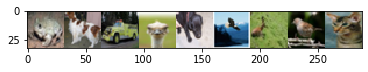

tensor([0.0075, 0.1699, 0.0425, 0.1624, 0.1409, 0.2203, 0.0129, 0.1129, 0.1308],
       device='cuda:0', dtype=torch.float64)


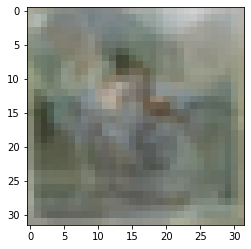

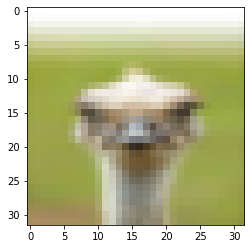

predicted ship
true truck
****************************************************************************************************


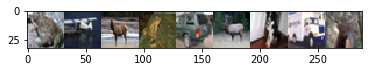

tensor([0.0116, 0.0294, 0.0082, 0.0023, 0.0131, 0.0016, 0.0115, 0.9128, 0.0096],
       device='cuda:0', dtype=torch.float64)


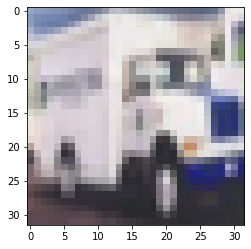

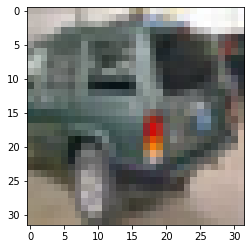

predicted truck
true truck
****************************************************************************************************


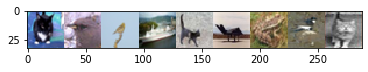

tensor([7.1746e-05, 5.5658e-05, 1.1704e-05, 9.9953e-01, 1.0215e-05, 2.7596e-05,
        3.0790e-05, 1.2811e-04, 1.2936e-04], device='cuda:0',
       dtype=torch.float64)


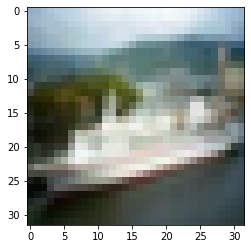

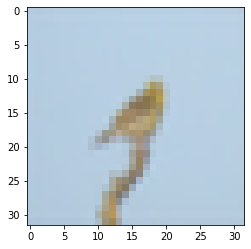

predicted ship
true ship
****************************************************************************************************


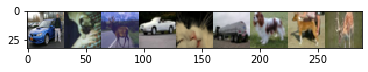

tensor([0.0337, 0.0189, 0.4227, 0.0642, 0.0150, 0.0677, 0.1764, 0.1593, 0.0423],
       device='cuda:0', dtype=torch.float64)


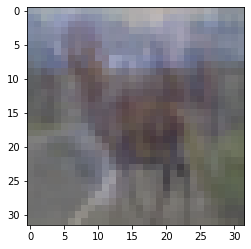

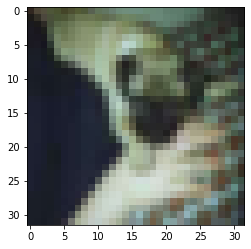

predicted horse
true truck
****************************************************************************************************


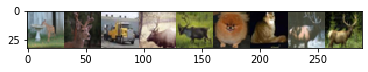

tensor([0.0213, 0.0319, 0.7830, 0.0485, 0.0296, 0.0129, 0.0353, 0.0121, 0.0253],
       device='cuda:0', dtype=torch.float64)


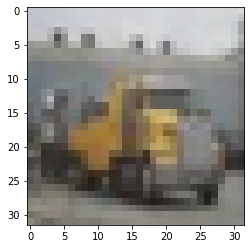

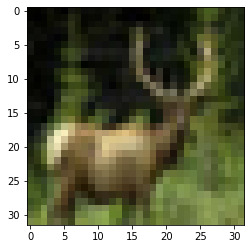

predicted truck
true truck
****************************************************************************************************


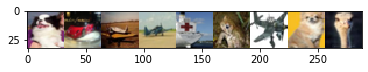

tensor([2.1930e-02, 2.6637e-02, 8.9486e-01, 1.4366e-02, 3.5189e-02, 1.4306e-03,
        1.3350e-03, 3.4360e-03, 8.1129e-04], device='cuda:0',
       dtype=torch.float64)


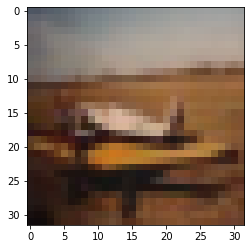

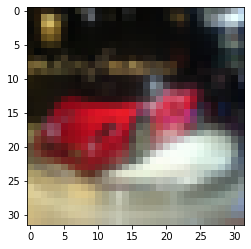

predicted ship
true ship
****************************************************************************************************


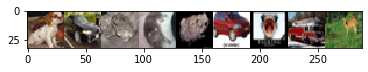

tensor([0.0134, 0.0058, 0.0326, 0.1030, 0.0261, 0.0617, 0.3387, 0.3828, 0.0359],
       device='cuda:0', dtype=torch.float64)


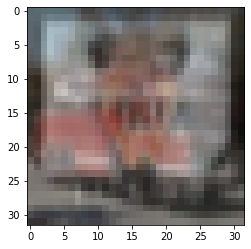

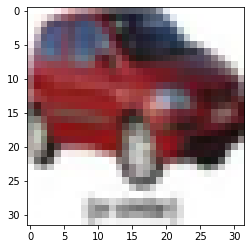

predicted truck
true truck
****************************************************************************************************


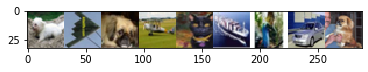

tensor([1.8033e-04, 2.0350e-04, 2.4552e-04, 5.5256e-04, 1.0687e-04, 9.9767e-01,
        1.3803e-04, 6.1186e-04, 2.9383e-04], device='cuda:0',
       dtype=torch.float64)


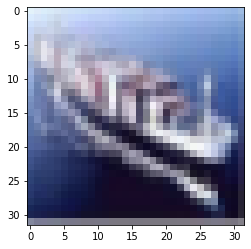

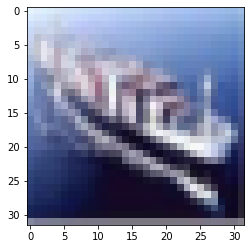

predicted ship
true ship
****************************************************************************************************


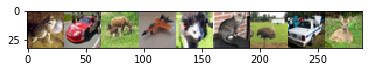

tensor([0.0647, 0.1055, 0.2156, 0.0441, 0.0443, 0.0903, 0.1643, 0.2180, 0.0532],
       device='cuda:0', dtype=torch.float64)


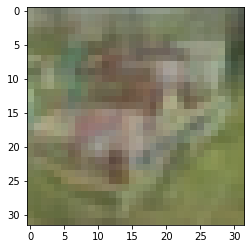

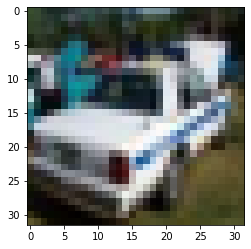

predicted horse
true horse
****************************************************************************************************


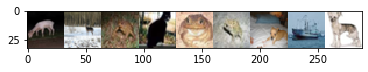

tensor([1.8744e-06, 1.3394e-06, 1.7834e-06, 1.3835e-06, 2.6722e-06, 1.7162e-06,
        2.9761e-06, 9.9997e-01, 2.0299e-05], device='cuda:0',
       dtype=torch.float64)


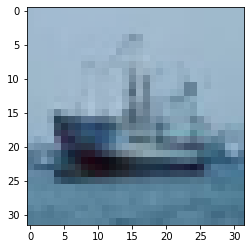

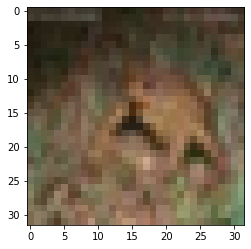

predicted ship
true ship
****************************************************************************************************


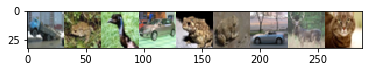

tensor([0.5003, 0.0176, 0.0596, 0.0490, 0.0089, 0.1605, 0.0425, 0.0882, 0.0734],
       device='cuda:0', dtype=torch.float64)


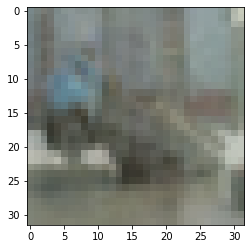

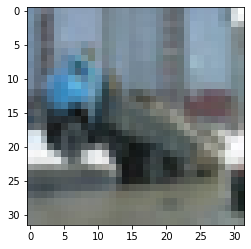

predicted truck
true truck
****************************************************************************************************


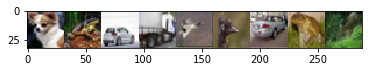

tensor([0.0012, 0.0040, 0.0246, 0.9465, 0.0043, 0.0115, 0.0028, 0.0013, 0.0037],
       device='cuda:0', dtype=torch.float64)


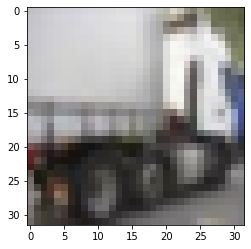

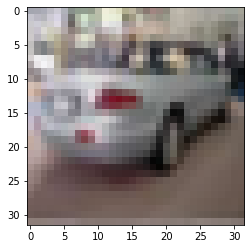

predicted truck
true truck
****************************************************************************************************


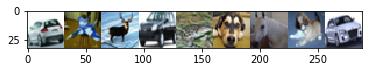

tensor([0.1481, 0.0518, 0.0081, 0.0475, 0.0030, 0.1975, 0.1452, 0.2634, 0.1354],
       device='cuda:0', dtype=torch.float64)


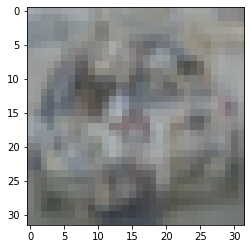

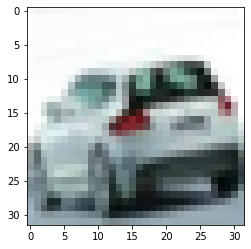

predicted ship
true horse
****************************************************************************************************


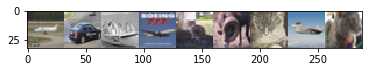

tensor([1.1334e-03, 2.5372e-04, 9.9087e-01, 6.8719e-04, 4.3459e-03, 1.0873e-06,
        9.7542e-04, 9.7807e-04, 7.5275e-04], device='cuda:0',
       dtype=torch.float64)


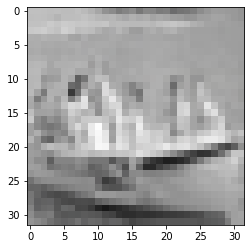

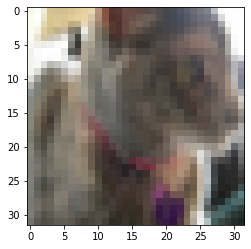

predicted ship
true ship
****************************************************************************************************


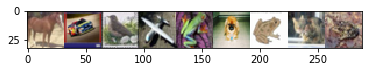

tensor([0.1560, 0.3040, 0.2326, 0.0080, 0.1452, 0.0670, 0.0390, 0.0255, 0.0228],
       device='cuda:0', dtype=torch.float64)


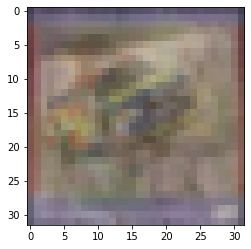

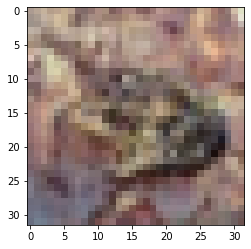

predicted truck
true horse
****************************************************************************************************


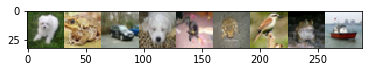

tensor([3.1878e-06, 8.6072e-06, 8.8763e-07, 2.3843e-06, 2.5977e-06, 3.0050e-06,
        9.2306e-07, 2.2626e-06, 9.9998e-01], device='cuda:0',
       dtype=torch.float64)


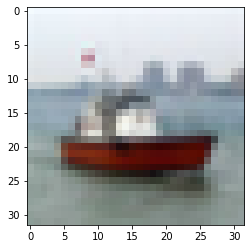

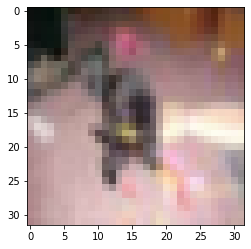

predicted ship
true ship
Accuracy of the network on the 10000 test images: 79 %
total correct 7962
total test set images 10000


In [77]:
correct = 0
total = 0
flag =1
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)


    if flag==1 :
      for j in range (50):
        print("*"*100)
        img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
        display(img1.cpu())

        print(alphas[j])

        img2 = avg_images[j]
        display(img2.cpu())

        img3 = inputs[j][fore_idx_test[j]]
        display(img3.cpu())

        print("predicted", classes[predicted[j]+7])
        print("true", classes[labels[j]+7])

      flag =0


    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
print("total correct", correct)
print("total test set images", total)

In [0]:
a = torch.tensor([0.0071, 0.0466, 0.0025, 0.0282, 0.0140, 0.0067, 0.0145, 0.8750, 0.0055])

In [79]:
print(torch.argmax(a) == 7)
print(batch)

tensor(True)
250


In [80]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

train_loader1 = DataLoader( msd,batch_size= batch ,shuffle=False)
with torch.no_grad():
  for data in train_loader1:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)
    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 97 %
total correct 29238
total train set images 30000
focus_true_pred_true 23703
focus_false_pred_true 5535
focus_true_pred_false 234
focus_false_pred_false 528
argmax_more_than_half 22611
argmax_less_than_half 7389


In [81]:
bg_idx = np.random.randint(0,35000,8)
fg_idx = np.random.randint(0,15000)
fg = np.random.randint(0,9)
fore_idx_test.append(fg)
image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
test_images.append(image_list)
test_label.append(label)
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0

with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs,labels = inputs.to("cuda"),labels.to("cuda") 
    avg_images , alphas = where_net(inputs)
    outputs = what_net(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    for j in range (batch):
      focus = torch.argmax(alphas[j])
      
      if(alphas[j][focus] >= 0.5):
        argmax_more_than_half +=1
      else:
        argmax_less_than_half +=1
        
      if(focus == fore_idx[j] and predicted[j] == labels[j]):
        focus_true_pred_true += 1
        
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true +=1
        
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false +=1
        
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false +=1
      
#       print("*"*100)
#       img1 = torch.cat((inputs[j][0], inputs[j][1], inputs[j][2], inputs[j][3], inputs[j][4], inputs[j][5], inputs[j][6], inputs[j][7], inputs[j][8]) , 2)
#       display(img1)

#       print(alphas[j])

#       img2 = avg_images[j]
#       display(img2)

#       img3 = inputs[j][fore_idx[j]]
#       display(img3)

#       print("predicted", classes[predicted[j]+7])
#       print("true", classes[labels[j]+7])

     
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %d %%' % (
    100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true",focus_true_pred_true)
print("focus_false_pred_true",focus_false_pred_true )
print("focus_true_pred_false",focus_true_pred_false )
print("focus_false_pred_false",focus_false_pred_false)

print("argmax_more_than_half",argmax_more_than_half)
print("argmax_less_than_half",argmax_less_than_half)

Accuracy of the network on the 30000 train images: 79 %
total correct 7962
total train set images 10000
focus_true_pred_true 6935
focus_false_pred_true 1027
focus_true_pred_false 538
focus_false_pred_false 1500
argmax_more_than_half 6964
argmax_less_than_half 3036


In [0]:
# epoch = 100
# for i in range(epoch):
#   if (i %40) <20:
#     print("What",i)
#   elif (i%40)>20:
#     print("Where",i)